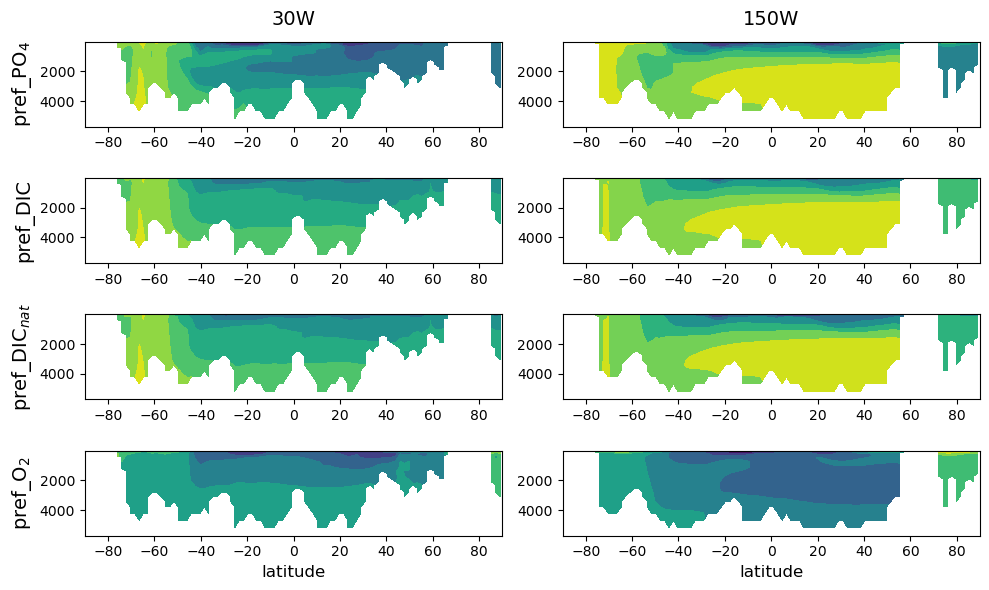

In [19]:
import xarray as xr
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
import pandas as pd

infile    = "/work/uo1451/m301158/MPI-ESM/data/test_flat10/raw/preform_spinup/"
outfile   = "/work/uo1451/m301158/MPI-ESM/image/"

f1 = nc.Dataset(infile+"preform_spinup_150W_1850-6062.nc", 'r') # exp1
pref_O2_150w=f1.variables['preformed_O2'][-1,:,:,0]
pref_PO4_150w=f1.variables['preformed_PO4'][-1,:,:,0]
pref_DIC_150w=f1.variables['preformed_DIC'][-1,:,:,0]
pref_DICnat_150w=f1.variables['preformed_DICnat'][-1,:,:,0]
dep=f1.variables['depth'][:]
lat=f1.variables['lat'][:]

f2 = nc.Dataset(infile+"preform_spinup_30W_1850-6062.nc", 'r') # exp2
pref_O2_30w=f2.variables['preformed_O2'][-1,:,:,0]
pref_PO4_30w=f2.variables['preformed_PO4'][-1,:,:,0]
pref_DIC_30w=f2.variables['preformed_DIC'][-1,:,:,0]
pref_DICnat_30w=f2.variables['preformed_DICnat'][-1,:,:,0]

plot_data=[ 
    ('pref_PO$_4$',pref_PO4_30w,'30W',''),
    ('' ,pref_PO4_150w,'150W',''),
    ('pref_DIC',pref_DIC_30w,'',''),
    ('',pref_DIC_150w,'',''),
    ('pref_DIC$_{nat}$',pref_DICnat_30w,'',''),
    ('',pref_DICnat_150w,'',''),
    ('pref_O$_2$',pref_O2_30w,'','latitude'),
    ('',pref_O2_150w,'','latitude')
]

fig,axes = plt.subplots(4,2,figsize=(10,6))
axes = axes.flatten()

for i, (ylabel, data, title,xlabel) in enumerate (plot_data):
    ax=axes[i]
    ax.contourf(lat,dep,data)
    ax.set_title(title,pad=12,fontsize=14)
    ax.set_xlim(-90,90)
    ax.set_xlabel(xlabel,fontsize=12)
    ax.set_ylabel(ylabel,fontsize=14)
    ax.invert_yaxis()
fig.tight_layout(h_pad=2) 

Saved to: /work/uo1451/m301158/MPI-ESM/image/preformed_sections_30W_150W_lasttime_clean_gridspec.png


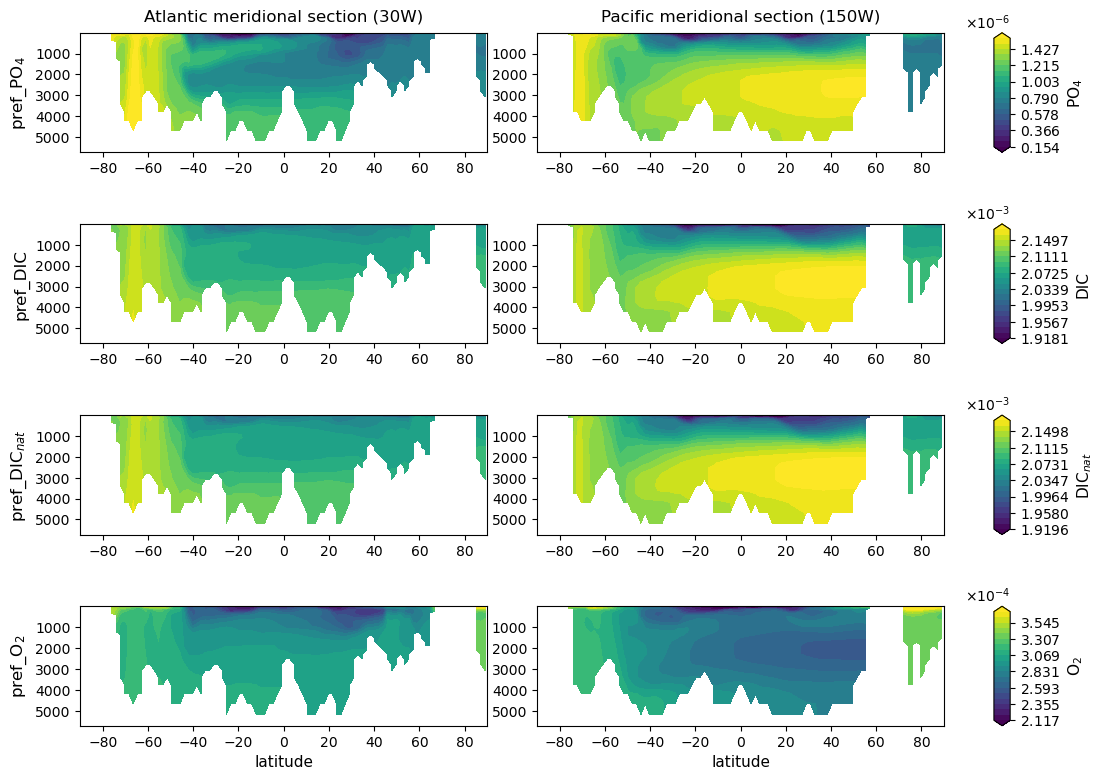

In [31]:
import os
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter, MultipleLocator

# 경로
infile  = "/work/uo1451/m301158/MPI-ESM/data/test_flat10/raw/preform_spinup/"
outfile = "/work/uo1451/m301158/MPI-ESM/image/"
os.makedirs(outfile, exist_ok=True)

# 파일 열기 (+ 자동 마스크/스케일)
f150 = nc.Dataset(infile + "preform_spinup_150W_1850-6062.nc", 'r')  # 150W
f030 = nc.Dataset(infile + "preform_spinup_30W_1850-6062.nc",  'r')  # 30W
f150.set_auto_maskandscale(True)
f030.set_auto_maskandscale(True)

# 좌표
dep = f150.variables['depth'][:]  # (depth,)
lat = f150.variables['lat'][:]    # (lat,)

# 마지막 시점 단면 + 결측/초대값 정리
def last_section_clean(ds, var):
    v   = ds.variables[var]
    arr = v[-1, :, :, 0]  # (depth, lat) 가정
    if np.ma.isMaskedArray(arr):
        arr = arr.filled(np.nan)
    for bad in (getattr(v, '_FillValue', None), getattr(v, 'missing_value', None)):
        if bad is not None:
            arr = np.where(arr == bad, np.nan, arr)
    arr = np.where(np.abs(arr) > 1e20, np.nan, arr)  # 비정상 초대값 제거
    return arr.astype(float)

# 데이터 로드
Z = {
    "PO4_30"  : last_section_clean(f030, 'preformed_PO4'),
    "PO4_150" : last_section_clean(f150, 'preformed_PO4'),
    "DIC_30"  : last_section_clean(f030, 'preformed_DIC'),
    "DIC_150" : last_section_clean(f150, 'preformed_DIC'),
    "DICn_30" : last_section_clean(f030, 'preformed_DICnat'),
    "DICn_150": last_section_clean(f150, 'preformed_DICnat'),
    "O2_30"   : last_section_clean(f030, 'preformed_O2'),
    "O2_150"  : last_section_clean(f150, 'preformed_O2'),
}

# 행(변수) 정의: (y축라벨, 왼쪽키, 오른쪽키, 컬러바라벨)
rows = [
    ("pref_PO$_4$",      "PO4_30",  "PO4_150",  "PO$_4$"),
    ("pref_DIC",         "DIC_30",  "DIC_150",  "DIC"),
    ("pref_DIC$_{nat}$", "DICn_30", "DICn_150", "DIC$_{nat}$"),
    ("pref_O$_2$",       "O2_30",   "O2_150",   "O$_2$")
]

# --- 레이아웃: 3열(30W, 150W, 컬러바) ---
fig = plt.figure(figsize=(12, 9))
gs  = fig.add_gridspec(nrows=4, ncols=3, width_ratios=[20, 20, 0.8],
                       wspace=0.18, hspace=0.6)

axesL, axesR, caxes = [], [], []
for r in range(4):
    axesL.append(fig.add_subplot(gs[r, 0]))
    axesR.append(fig.add_subplot(gs[r, 1]))
    caxes.append(fig.add_subplot(gs[r, 2]))   # 컬러바 전용 축

for r, (ylabel, keyL, keyR, cbar_label) in enumerate(rows):
    axL, axR, cax = axesL[r], axesR[r], caxes[r]
    ZL, ZR = Z[keyL], Z[keyR]

    # 스케일: NaN 제외 2–98 퍼센타일
    flat = np.concatenate([ZL.ravel(), ZR.ravel()])
    low  = np.nanpercentile(flat, 2)
    high = np.nanpercentile(flat, 98)
    if not np.isfinite(low) or not np.isfinite(high) or low == high:
        levels = 21; vmin = vmax = None
    else:
        levels = np.linspace(low, high, 21)
        vmin, vmax = low, high

    # 30W
    cfL = axL.contourf(lat, dep, ZL, levels=levels, vmin=vmin, vmax=vmax, extend='both')
    axL.set_title("Atlantic meridional section (30W)" if r == 0 else "", pad=8, fontsize=12)
    axL.set_xlim(-90, 90)
    axL.set_ylabel(ylabel, fontsize=12)
    axL.set_xlabel("" if r < 3 else "latitude", fontsize=11)
    axL.invert_yaxis()
    axL.yaxis.set_major_locator(MultipleLocator(1000))

    # 150W
    cfR = axR.contourf(lat, dep, ZR, levels=levels, vmin=vmin, vmax=vmax, extend='both')
    axR.set_title("Pacific meridional section (150W)" if r == 0 else "", pad=8, fontsize=12)
    axR.set_xlim(-90, 90)
    axR.set_ylabel("")
    axR.set_xlabel("" if r < 3 else "latitude", fontsize=11)
    axR.invert_yaxis()
    axR.yaxis.set_major_locator(MultipleLocator(1000))

    # 행 공통 컬러바(전용 축에 배치 → 플롯과 절대 안 겹침)
    cbar = fig.colorbar(cfL, cax=cax)
    cbar.set_label(cbar_label, fontsize=11)
    fmt = ScalarFormatter(useMathText=True)
    fmt.set_powerlimits((-3, 3))
    cbar.formatter = fmt
    cbar.update_ticks()

# 저장
save_path = os.path.join(outfile, "preformed_sections_30W_150W_lasttime_clean_gridspec.png")
plt.savefig(save_path, dpi=300, bbox_inches="tight")
print("Saved to:", save_path)

# 닫기
f150.close(); f030.close()

